In [ ]:
### Replace these parameters with papermill parameters when running the notebook
CONFIG_FILE = "config/benchmark/scipy_rq.json"

REPO_NAME: str = "scipy/scipy"

ARTIFACT_FOLDER: str = "../data/test_augmentation/001/scipy"

GENERATOR_NAME_KEY = "Full ChaCo"
FOLDER_WITH_TESTS = "chaco_full"

In [ ]:
# Parameters
CONFIG_FILE = "config/benchmark/scipy_example.json"
REPO_NAME = "scipy/scipy"
ARTIFACT_FOLDER = "../data/test_augmentation/001/scipy"
GENERATOR_NAME_KEY = "Full ChaCo"
FOLDER_WITH_TESTS = "chaco_full"


Run this via papermill to execute the notebook with the specified parameters.:
```bash
papermill example_results.ipynb scipy_results.ipynb \
  -p CONFIG_FILE "config/benchmark/{your PRs}.json" \
  -p REPO_NAME "scipy/scipy" \
  -p ARTIFACT_FOLDER "../data/test_augmentation/001/scipy" \
  -p GENERATOR_NAME_KEY "Full ChaCo" \
  -p FOLDER_WITH_TESTS "chaco_full"
```

#### Load the config file storing the benchmark PRs 

In [ ]:
import re
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

INFO: Pandarallel will run on 48 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/ericzhou/miniconda3/envs/chaco/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# For the example, we only ran Full ChaCo, so we only have one generator here.
GENERATORS = {
    GENERATOR_NAME_KEY: FOLDER_WITH_TESTS,
}

In [ ]:
PATH_GITHUB_TOKEN: str = "../../../secrets/github_token.txt"

if isinstance(ARTIFACT_FOLDER, str):
    ARTIFACT_FOLDER = Path(ARTIFACT_FOLDER)
ARTIFACT_FOLDER.mkdir(parents=True, exist_ok=True)
print(f"Artifacts folder: {ARTIFACT_FOLDER}")

print("Repo name:", REPO_NAME)

ARTIFACT_FOLDER_PATH = Path(ARTIFACT_FOLDER)
GENERATORS_FOLDERS = {
    name: ARTIFACT_FOLDER_PATH / "test_cases" / dir_name for name,
    dir_name in GENERATORS.items()}

GENERATORS

Artifacts folder: ../data/test_augmentation/001/scipy
Repo name: scipy/scipy


{'Change and Cover with Dynamic Context': 'chaco_full'}

In [6]:
sys.path.append("../")

In [ ]:
# read the config file to get the list of PRs benchmarked
PREFIX = Path("../")

with open(PREFIX / CONFIG_FILE, "r") as f:
    pr_file = json.load(f)
    pr_list = pr_file["projects"][REPO_NAME]["pr_numbers"]
    print("Number of PRs used for benchmarking:", len(pr_list))
    print("PR list:", pr_list)

Number of PRs used for benchmarking: 10
PR list: [24056, 24092, 24118, 24119, 24133, 24134, 24172, 24179, 24185, 24234]


In [ ]:
def load_test_data(generators_folders, pr_list, pattern):
    """
    Reads test files, runtime logs, and coverage increments into a nested dictionary.
    TEST_DATA[generator][pr_number] = list of test records (dict).

    Each test record contains:
        - test_name: str
        - test_content: str
        - runtime_log: str or None
        - coverage_increment: dict or None
    """
    test_data = {}

    for generator, folder in generators_folders.items():
        test_data.setdefault(generator, {})

        # For each PR in pr_list, build a path and gather test files
        for pr in pr_list:
            pr_dir = Path(folder) / str(pr)
            if not pr_dir.exists():
                print(
                    f"WARNING: {generator}, PR dir {pr_dir} does not exist, skipping...")
                continue

            test_data[generator].setdefault(str(pr), [])

            # Gather all test_*.py files
            test_paths = sorted(pr_dir.glob("test_*.py"))

            # Filter out test files not following the pattern
            if pattern:
                test_paths = [p for p in test_paths
                              if re.search(pattern, p.name)]

            for test_path in test_paths:
                # Skip files that are not regular files
                if not test_path.is_file():
                    print(
                        f"WARNING: {generator}, PR {pr}, {test_path} is not a file, skipping...")
                    continue

                test_name = test_path.stem  # e.g. test_1

                with open(test_path, "r") as f:
                    test_content = f.read()

                # The runtime log file is assumed to be test_1_runtime.log, etc.
                runtime_log_path = pr_dir / f"{test_name}_runtime.log"
                if runtime_log_path.exists():
                    with open(runtime_log_path, "r") as f:
                        runtime_log_content = f.read()
                else:
                    runtime_log_content = None

                # Coverage increment json is assumed to be test_1_coverage_increment.json
                coverage_inc_path = pr_dir / \
                    f"{test_name}_coverage_increment.json"
                if coverage_inc_path.exists():
                    with open(coverage_inc_path, "r") as f:
                        coverage_inc_data = json.load(f)
                else:
                    coverage_inc_data = None

                test_data[generator][str(pr)].append({
                    "test_name": test_name,
                    "test_content": test_content,
                    "runtime_log": runtime_log_content,
                    "coverage_increment": coverage_inc_data
                })

    return test_data

# Build INTEGRATED_TEST_DATA:
INTEGRATED_TEST_DATA = load_test_data(GENERATORS_FOLDERS, pr_list,
                                      pattern=r"test_[0-9]+_integrated.py")

In [ ]:
def split_coverage_line(line: str):
    """
    Split a coverage line into its components.
    e.g.,
    "scipy/signal/_spline_filters.py:594:c" -> ("scipy/signal/_spline_filters.py", 594)
    """
    line_parts = line.split(":")
    if len(line_parts) == 3:
        return (line_parts[0], int(line_parts[1]))
    else:
        print(f"WARNING: Unexpected line format: {line}")
        exit(1)


def aggregate_generators(test_data):
    """
    Aggregates data across ALL PRs for each generator:
     - #tests (sum)
     - #passed, #failed, #skipped, #errored (sum)
     - pass rate (passed / total)
     - total unique lines covered (deduplicated across all PRs)
     - # PRs with coverage added vs. # all PRs
    Prints the results.

    Return four dictionaries:
        - all_prs
        - pass_rates_by_gen_pr
        - coverage_added_by_gen_pr
        - coverage_added_by_gen_pr_passing_tests

    """

    all_prs = set()
    pass_rates_by_gen_pr = {}
    coverage_added_by_gen_pr = {}
    coverage_added_by_gen_pr_passing_tests = {}

    print("\n=== AGGREGATE STATISTICS ===")
    for generator, pr_dict in test_data.items():
        gen_total_tests = 0
        gen_passed = 0
        gen_failed = 0
        gen_skipped = 0
        gen_errored = 0

        # One set of lines for the entire generator
        gen_all_unique_lines = set()
        gen_all_unique_lines_passing_tests = set()

        # Track how many PRs actually added coverage
        coverage_added_pr_count = 0
        coverage_added_pr_count_passing_tests = 0
        total_prs_for_generator = len(pr_dict)

        for pr_number, tests_info in pr_dict.items():

            all_prs.add(pr_number)  # Collect all PR numbers

            # Collect coverage lines for this PR
            pr_covered_lines = set()
            pr_covered_lines_passing_tests = set()

            #
            pr_passed = 0
            pr_failed = 0
            pr_skipped = 0
            pr_errored = 0

            for test_record in tests_info:
                # Overall test counters
                gen_total_tests += 1
                passed_flag = False

                runtime_log = test_record["runtime_log"] or ""
                if "failed" in runtime_log:
                    gen_failed += 1
                    pr_failed += 1
                elif "skipped" in runtime_log:
                    gen_skipped += 1
                    pr_skipped += 1
                elif "error" in runtime_log:
                    gen_errored += 1
                    pr_errored += 1
                elif "passed" in runtime_log:
                    gen_passed += 1
                    pr_passed += 1
                    passed_flag = True
                else:
                    # warning
                    pass
                    # print(f"WARNING: Unrecognized log for {generator}, PR={pr_number}, test={test_record['test_name']}")

                # Coverage lines
                coverage_data = test_record["coverage_increment"]
                if coverage_data:

                    lines_this_test = coverage_data.get(
                        "unique_lines_covered", [])
                    lines_this_test = [
                        (split_coverage_line(line)[0],
                         split_coverage_line(line)[1])
                        for line in lines_this_test]

                    line_missed_by_dev = coverage_data.get(
                        "line_missed_by_dev", [])
                    line_missed_by_dev = [
                        (split_coverage_line(line)[0],
                         split_coverage_line(line)[1])
                        for line in line_missed_by_dev]

                    lines_increment = set(lines_this_test) & set(
                        line_missed_by_dev)

                    # IMPORTANT: filter out coverage of lines that are added in a test file
                    # print(lines_this_test)
                    lines_increment = [
                        (fp, lineno) for fp, lineno in lines_increment
                        if not re.search(r"test", fp)]

                    pr_covered_lines.update(lines_increment)
                    if passed_flag:
                        pr_covered_lines_passing_tests.update(lines_increment)

            # If the PR has any coverage lines, it counts as coverage added
            if len(pr_covered_lines) > 0:
                coverage_added_pr_count += 1
            if len(pr_covered_lines_passing_tests) > 0:
                coverage_added_pr_count_passing_tests += 1

            # Update the generator-level coverage set
            gen_all_unique_lines.update(pr_covered_lines)
            gen_all_unique_lines_passing_tests.update(
                pr_covered_lines_passing_tests)

            # Store the Per PR statistics
            pass_rates_by_gen_pr.setdefault(generator, {})[
                pr_number] = pr_passed / len(tests_info) * 100 if len(tests_info) else 0.0
            coverage_added_by_gen_pr.setdefault(
                generator, {})[pr_number] = len(pr_covered_lines)
            coverage_added_by_gen_pr_passing_tests.setdefault(
                generator, {})[pr_number] = len(
                pr_covered_lines_passing_tests)

        # Summary for this generator across ALL PRs
        generator_pass_rate = (
            gen_passed / gen_total_tests) * 100 if gen_total_tests else 0.0
        generator_unique_lines_covered = len(gen_all_unique_lines)
        generator_unique_lines_passing_tests = len(
            gen_all_unique_lines_passing_tests)

        print(f"\n[Generator={generator}]")
        print(f"  - Total tests across all PRs: {gen_total_tests}")
        print(
            f"  - Passed: {gen_passed}, Failed: {gen_failed}, Skipped: {gen_skipped}, Errored: {gen_errored}")
        print(f"  - Pass Rate (overall): {generator_pass_rate:.1f}%")
        print(
            f"  - Total unique lines covered: {generator_unique_lines_covered}")
        print(
            f"  - Total unique lines covered by passing tests: {generator_unique_lines_passing_tests}")
        print(
            f"  - PRs with coverage added / total PRs: {coverage_added_pr_count}/{total_prs_for_generator}")
        print(
            f"  - PRs with coverage added by passing tests / total PRs: {coverage_added_pr_count_passing_tests}/{total_prs_for_generator}")

    # return the dictionaries for further analysis
    return all_prs, pass_rates_by_gen_pr, coverage_added_by_gen_pr, coverage_added_by_gen_pr_passing_tests

In [ ]:
def plot_coverage_added_by_passing_tests(
        coverage_passing_by_gen_pr, all_prs, generators, title_suffix=""):
    plt.figure()  # distinct plot
    x = np.arange(len(all_prs))
    bar_width = 0.8 / len(generators)
    for i, gen_name in enumerate(generators):
        pr_coverages = [coverage_passing_by_gen_pr[gen_name].get(
            pr, 0) for pr in all_prs]
        offset = i * bar_width
        plt.bar(x + offset, pr_coverages, width=bar_width, label=gen_name)

    plt.xticks(x + bar_width*(len(generators)-1)/2, all_prs, rotation=65)
    plt.xlabel("PR Number")
    plt.ylabel("New Lines of Coverage (by passing tests)")
    plt.title(
        "Coverage Added per PR by *Passing* Tests" +
        title_suffix)
    plt.legend()
    plt.tight_layout()
    plt.show()


=== AGGREGATE STATISTICS (COMPARING GENERATORS) ===

[Generator=Change and Cover with Dynamic Context - Aggregate]
  - Total tests across all PRs: 689
  - Passed: 170, Failed: 307, Skipped: 20, Errored: 145
  - Pass Rate (overall): 24.7%
  - Total unique lines covered: 88
  - Total unique lines covered by passing tests: 57
  - PRs with coverage added / total PRs: 25/50
  - PRs with coverage added by passing tests / total PRs: 21/50


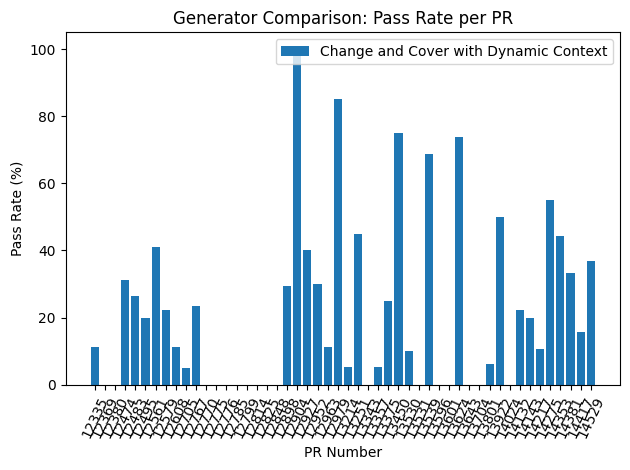

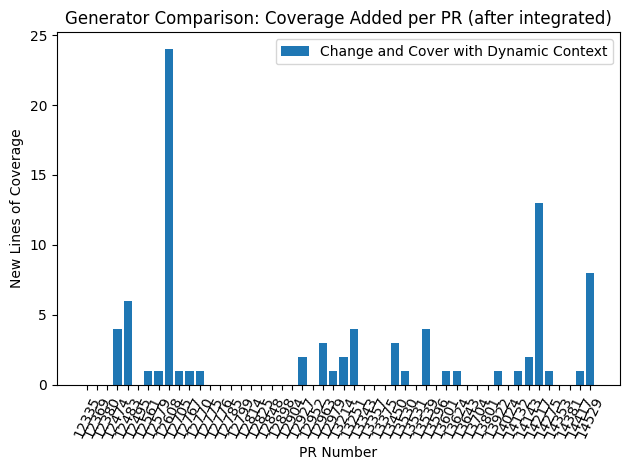

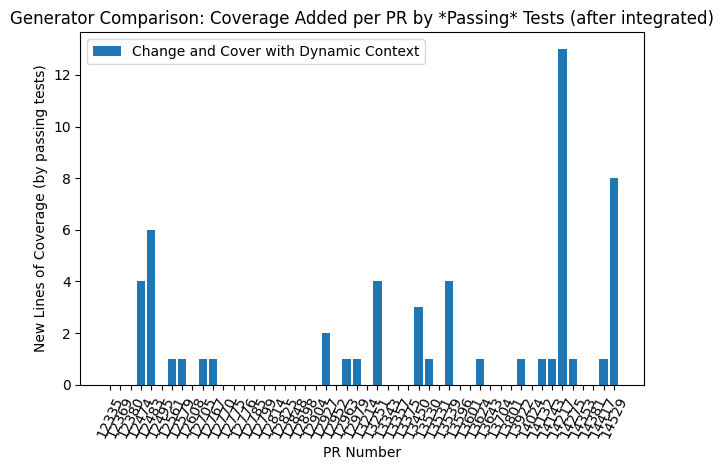

In [ ]:
all_prs, pass_rates_by_gen_pr, coverage_by_gen_pr, coverage_passing_by_gen_pr = \
    aggregate_generators(INTEGRATED_TEST_DATA)

##############################################################################
# Convert all_prs to a sorted list for consistent plotting
all_prs = sorted(all_prs)
# Prepare one list of generator names
generators = sorted(INTEGRATED_TEST_DATA.keys())


plot_coverage_added_by_passing_tests(
    coverage_passing_by_gen_pr, all_prs, generators)

### Detailed Statistics on PR coverage improvement

In [1]:
from approach.utils.test_extractor import extract_names

# The number of uncovered lines in a PR
def get_uncovered_lines_in_pr(
        pr_number: str, artifact_folder: Path) -> int:
    """
    Given a PR number, repo name, and artifact folder, return the number of uncovered lines in that PR.
    Filter out lines that are top-level (i.e. not in a function)

    The format of the relevance file:
    {
        "pandas/core/apply.py": {
            "covered": [
                1828,
                1829,
                ...
            ],
            "missed": []
        },
        "pandas/tests/groupby/aggregate/test_aggregate.py": {
            "covered": [
                65,
                67,
                68,
                ...
            ],
            "missed": []
        }
    }
    """
    #
    num_uncovered_lines = 0

    # read the relevance file
    relevance_file = artifact_folder / "coverage" / \
        str(pr_number) / "current_relevance.json"

    if not relevance_file.exists():
        print(
            f"WARNING: Relevance file {relevance_file} does not exist, returning 0 uncovered lines.")
        return 0

    with open(relevance_file, "r") as f:
        relevance_data = json.load(f)

        for fp in list(relevance_data.keys()):
            # if the file is a test file, ignore it
            if re.search(r"test", fp):
                continue
            # read the file
            abs_fp = artifact_folder / "file_content" / \
                str(pr_number) / "after" / fp
            if not abs_fp.exists():
                print(f"WARNING: File {abs_fp} does not exist, skipping...")
                continue
            with open(abs_fp, "r") as f2:
                file_str = f2.read()
            # get the missed lines
            missed_lines = relevance_data[fp].get("missed", [])

            for line in missed_lines:
                # extract the function name for this line
                try:
                    extract_names(
                        line=int(line),
                        file_content=file_str, file_path="")
                    num_uncovered_lines += 1
                except Exception as _:
                    # missing coverage is in an interested area, skip
                    pass

    return num_uncovered_lines


num_uncovered_lines = {
    pr: get_uncovered_lines_in_pr(pr, ARTIFACT_FOLDER)
    for pr in pr_list}
print("Uncovered lines per PR:", num_uncovered_lines)
print("Total uncovered lines across all PRs:",
      sum(num_uncovered_lines.values()))

# PRs that are fully covered after test generation
fully_covered_prs = [
    pr for pr, num in num_uncovered_lines.items()
    if num == coverage_passing_by_gen_pr.get(GENERATOR_NAME_KEY).get(
        str(pr),
        0)
    and num_uncovered_lines.get(pr, 0) > 0]

print("PRs that are fully covered after test generation:", fully_covered_prs)
print(
    "Number of PRs that are fully covered after test generation:",
    len(fully_covered_prs))


ratios = {}
for pr in pr_list:
    uncovered = num_uncovered_lines.get(pr, 0)
    added = coverage_passing_by_gen_pr.get(GENERATOR_NAME_KEY).get(str(pr), 0)

    if uncovered == 0:
        # No uncovered lines to cover, skip
        pass
    else:
        ratio = added / uncovered
        ratios[pr] = ratio
    # print(f"PR {pr}: {ratio:.2f}")
print("Average ratio of uncovered lines covered across all PRs:",
      np.mean(list(ratios.values())) if ratios else 0.0)
print("Ratios per PR:", ratios)

ModuleNotFoundError: No module named 'approach'